In [1]:
!pip install -U scikit-learn
!pip install matplotlib
!pip install seaborn

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
     |████████████████████████████████| 285 kB 1.7 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import functools
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import data_util_val
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
#plt Config
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [4]:
def build_input_fn(global_batch_size):
    #Build input function.
    #Args:
    #    global_batch_size: Global batch size.
    #Returns:
    #    A function that accepts a dict of params and returns a tuple of images and
    #    features, to be used as the input_fn in TPUEstimator.
    def _input_fn_(input_context):
        #Inner input function
        batch_size = input_context.get_per_replica_batch_size(global_batch_size)
        #logging.info('Global batch size: %d', global_batch_size)
        #logging.info('Per-replica batch size: %d', batch_size)
        preprocess_fn_finetune = get_preprocess_fn()
        num_classes = 5

        def map_fn(image, label):
            image = preprocess_fn_finetune(image)
            label = tf.one_hot(label, num_classes)
            return image, label

        #logging.info('Using Astro pretrain data')
        dataset = get_data_test()

        if input_context.num_input_pipelines > 1:
            dataset = dataset.shard(input_context.num_input_pipelines, input_context.input_pipeline_id)

        dataset = dataset.map(map_fn, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(batch_size, drop_remainder=True)
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
        return dataset

    return _input_fn_

def build_distributed_dataset(batch_size, strategy):
    input_fn = build_input_fn(batch_size)
    return strategy.experimental_distribute_datasets_from_function(input_fn)

def get_preprocess_fn():
    #Get function that accepts an image and returns a preprocessed image
    return functools.partial(
        data_util_val.preprocess_image,
        height = 330,
        width= 330)


def get_data_test():
    #logging.info('Loading Astro test data')
    data_dir = 'imagenes_clasificadas_nair/'
    def read_images(image_file, label):
        image = tf.io.read_file(data_dir + image_file)
        image = tf.image.decode_jpeg(image, channels = 3)
        return image, label
    
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    df = pd.read_csv('nair_unbalanced_train.csv')
    file_paths = df['name'].values
    labels = df['new_class'].values
    labels = tf.convert_to_tensor(labels, dtype=tf.int64)
    ds_test = tf.data.Dataset.from_tensor_slices((file_paths, labels))
    ds_test = ds_test.map(read_images, num_parallel_calls =AUTOTUNE)
    return ds_test

def get_number_of_images(path_to_csv):
    df = pd.read_csv(path_to_csv)
    return df.shape[0]

In [5]:
strategy = tf.distribute.MirroredStrategy()
ds = build_distributed_dataset(8, strategy)
iterator = iter(ds)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Instructions for updating:
rename to distribute_datasets_from_function


In [6]:
saved_model = tf.saved_model.load('checkpoint/saved_model/2513100/')

In [7]:
representations_list = []
for images, labels in iterator:
    representation = saved_model(images, trainable=False)['final_avg_pool']
    representation = representation.numpy()
    representations_list.append(representation)

In [8]:
logits = np.concatenate(np.array(representations_list, dtype=object), axis=0)
logits = logits.astype(np.float32)

In [9]:
kmeans = MiniBatchKMeans(n_clusters=5).fit_predict(logits)

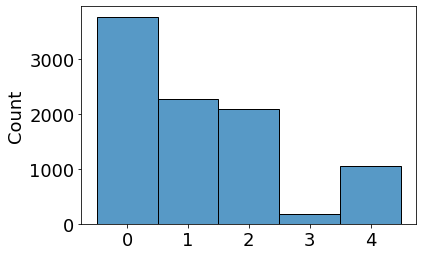

In [10]:
sns.histplot(kmeans, discrete=True)
plt.show()

In [16]:
kmeans = KMeans(n_clusters=5).fit(logits)

In [17]:
pseudolabels = kmeans.predict(logits)

In [18]:
transformed_data = kmeans.transform(logits)

In [38]:
values = pd.read_csv('nair_unbalanced_train.csv')
values = values['new_class'].values
values= values[:-1]

In [40]:
df = pd.DataFrame({'real_label': values, 'pseudolabel':pseudolabels})

In [54]:
df1 = pd.DataFrame(transformed_data)

In [48]:
df = df1.join(df)

In [50]:
array = df.to_numpy()

In [55]:
df1

,0,1,2,3,4
0,7.519646,3.990921,6.383593,5.552455,17.122906
1,6.447233,4.733723,4.144328,7.926029,18.571510
2,5.195087,8.413893,6.489885,10.893649,19.364439
3,4.468309,7.835480,8.317485,11.170568,19.586487
4,5.979910,3.624439,6.911340,8.107725,18.631508
...,...,...,...,...,...
9355,8.116875,5.981045,6.961185,8.288562,19.111176
9356,8.444783,6.258756,6.952814,4.637247,14.952685
9357,4.280786,7.639808,6.633518,10.714779,19.561060
9358,7.822980,10.298673,7.320283,12.468438,20.293562


# TSNE

In [11]:
tsn = TSNE(n_components=2, perplexity=100, learning_rate=300, metric='cosine')
df = tsn.fit_transform(logits)
df.shape

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


(9360, 2)

In [12]:
kmeans_1 = KMeans(n_clusters= 6, algorithm='elkan')
label = kmeans_1.fit_predict(df)
u_labels = np.unique(label)
centroids = kmeans_1.cluster_centers_

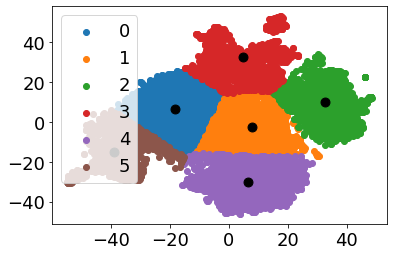

In [13]:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

## PCA

In [14]:
pca = PCA(2, svd_solver='full')
df = pca.fit_transform(logits)
df.shape

(9360, 2)

In [15]:
kmeans_1 = KMeans(n_clusters= 6)
label = kmeans_1.fit_predict(df)
print(label)

[0 5 1 ... 1 1 5]


In [16]:
u_labels = np.unique(label)
centroids = kmeans_1.cluster_centers_

In [17]:
u_labels

array([0, 1, 2, 3, 4, 5], dtype=int32)

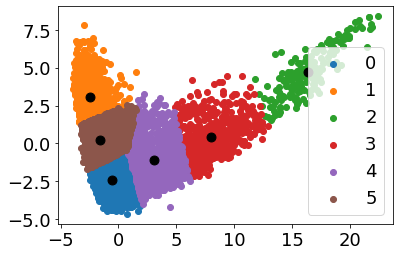

In [18]:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

# ICA

In [19]:
from sklearn.decomposition import FastICA
ica = FastICA(2, max_iter=1000, tol=0.1)
df = ica.fit_transform(logits)
df.shape

(9360, 2)

In [20]:
kmeans_1 = KMeans(n_clusters= 6)
label = kmeans_1.fit_predict(df)
u_labels = np.unique(label)
centroids = kmeans_1.cluster_centers_

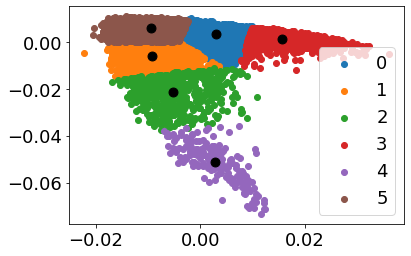

In [21]:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.scatter(centroids[:,0] , centroids[:,1] , s = 80, color = 'k')
plt.legend()
plt.show()

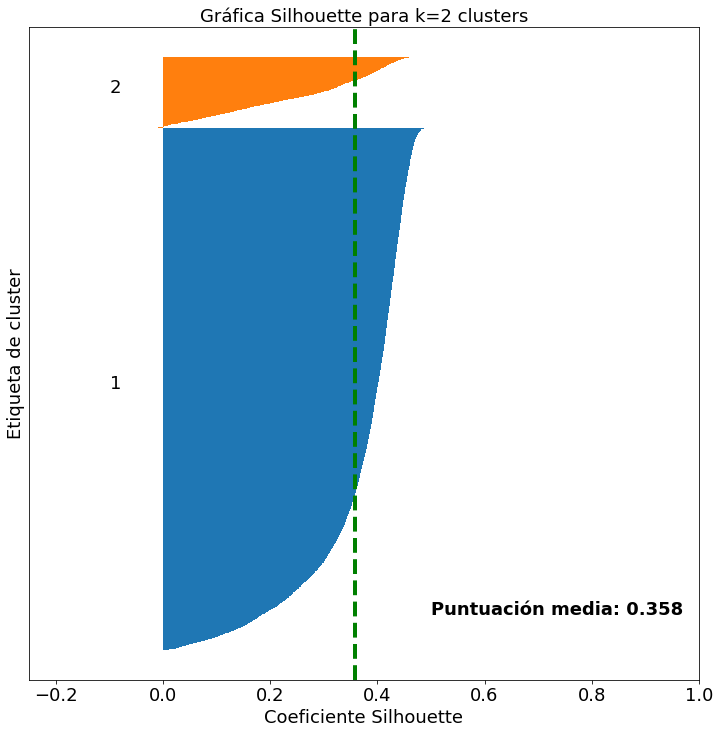

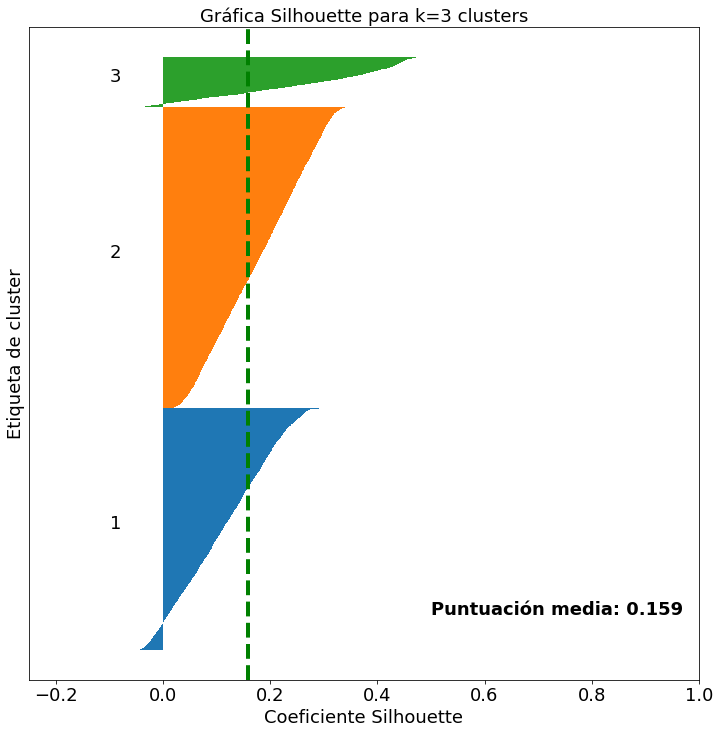

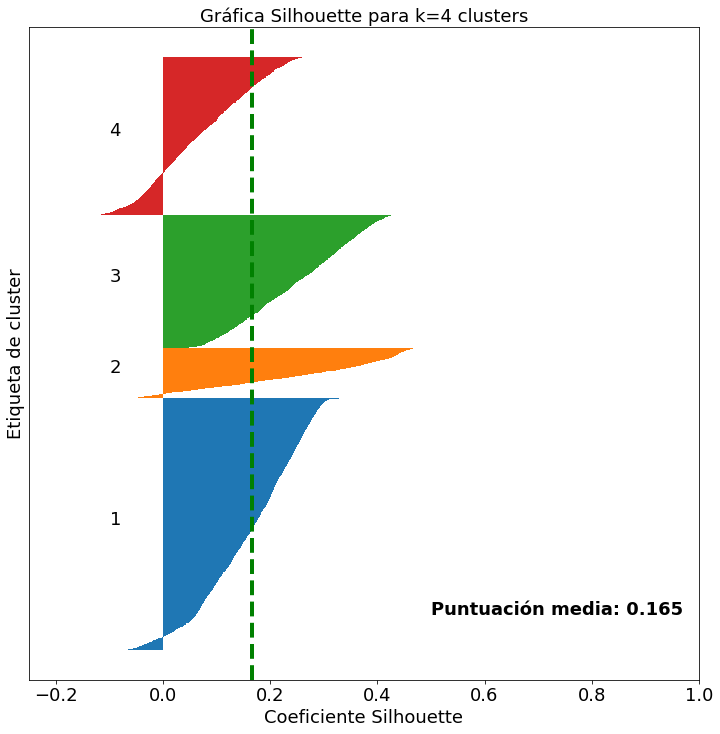

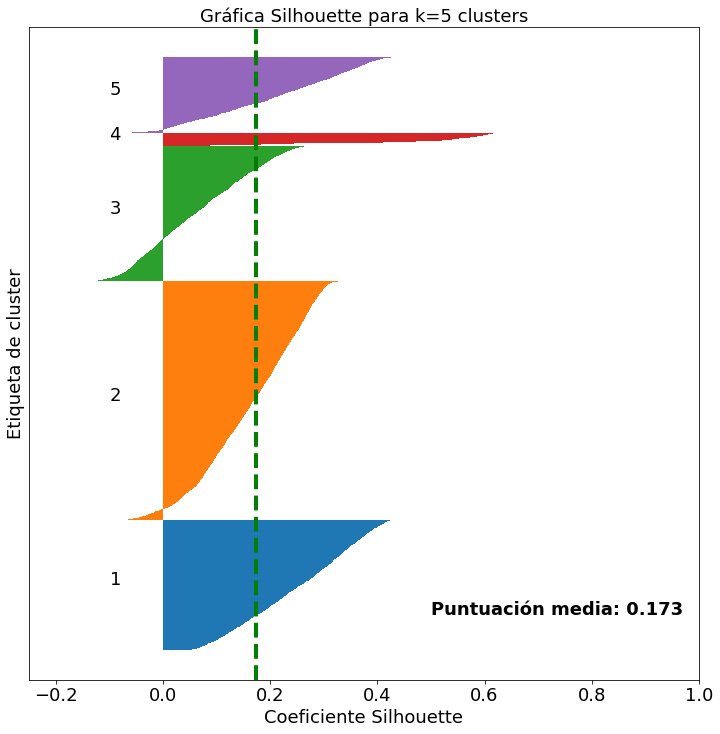

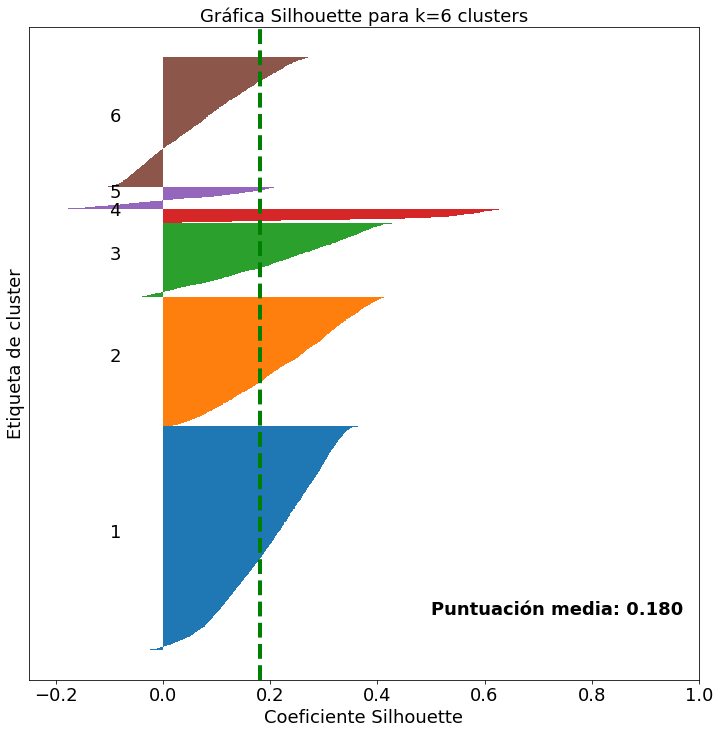

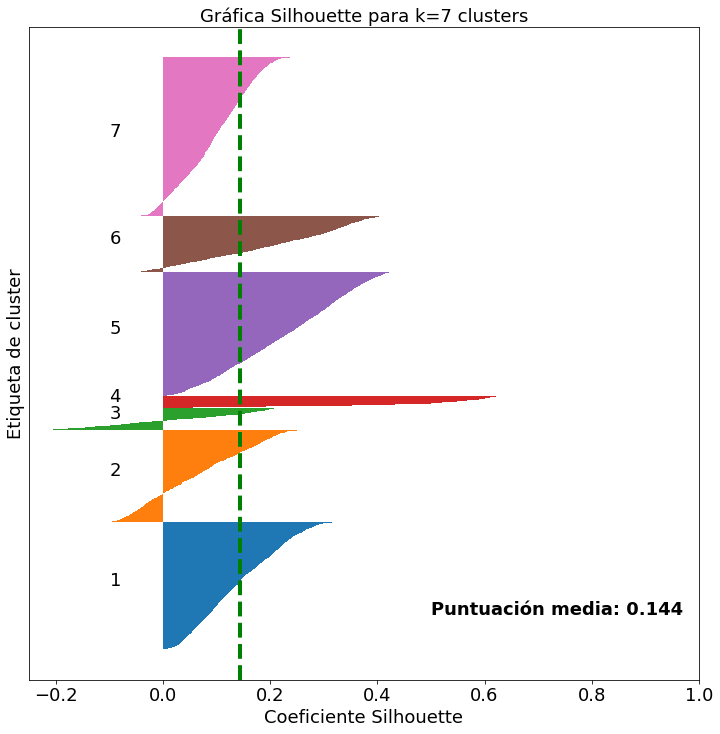

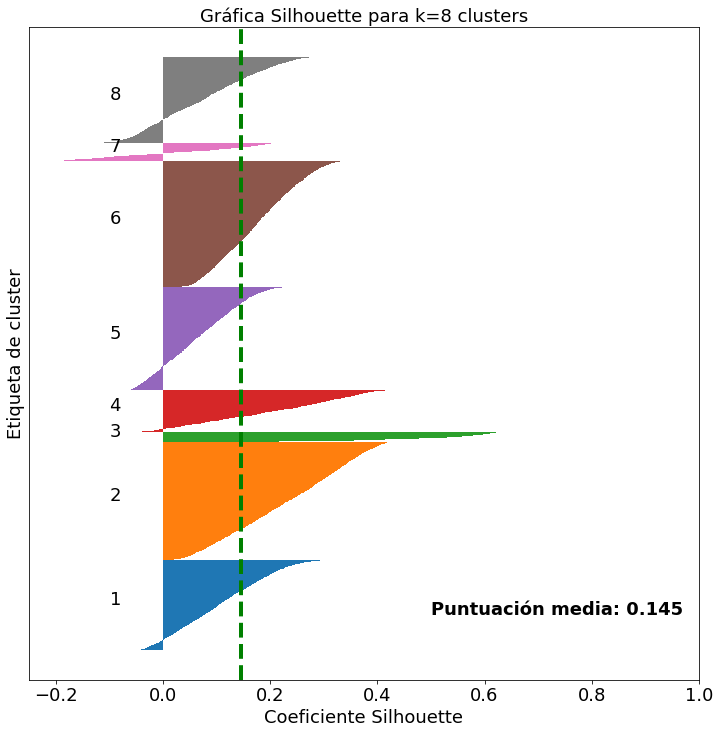

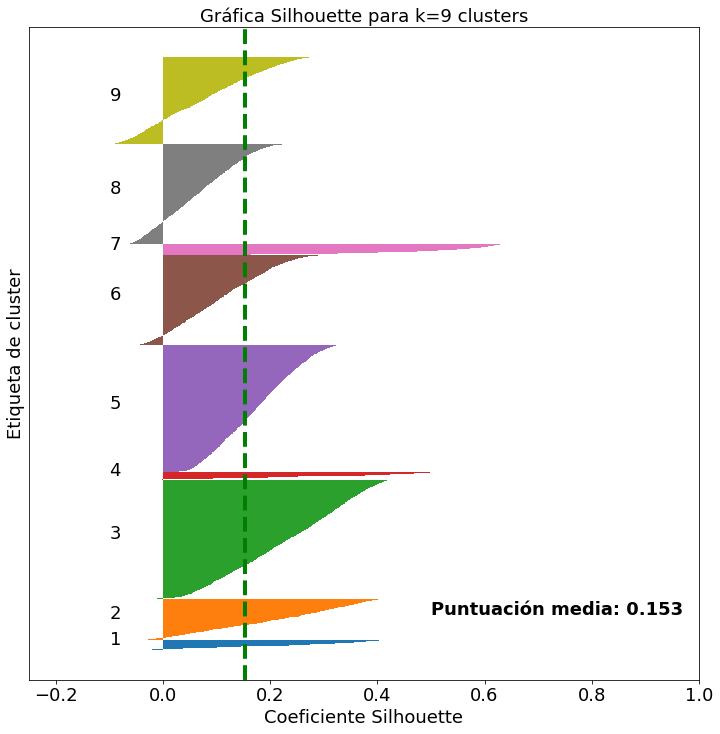

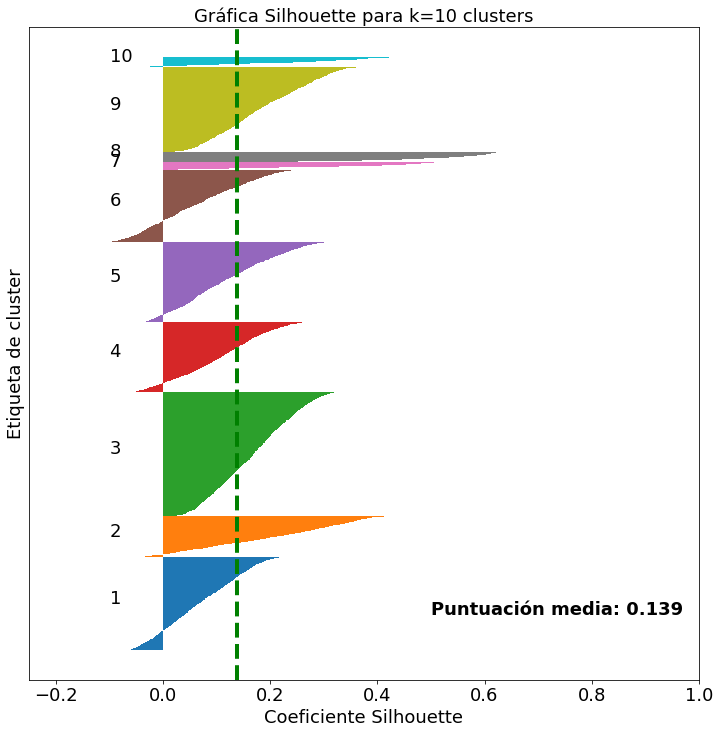

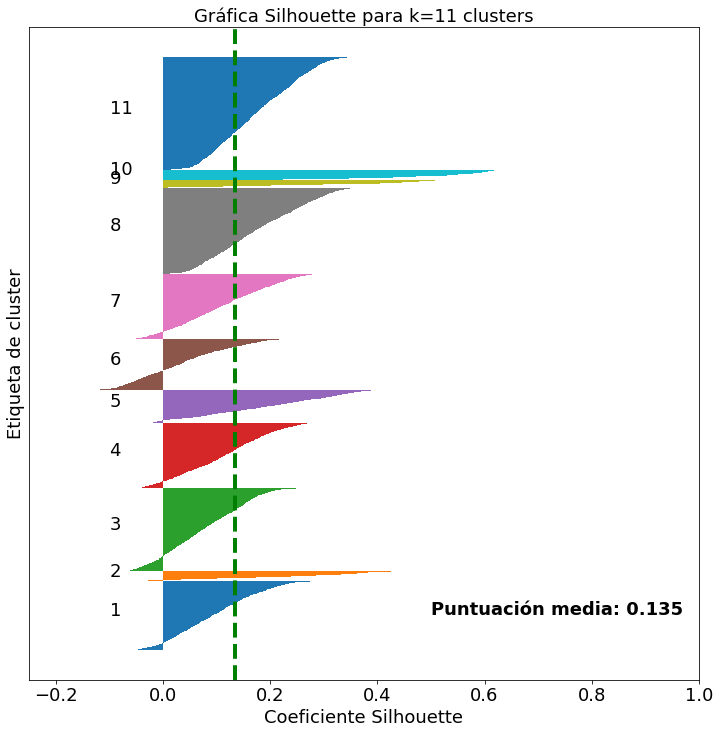

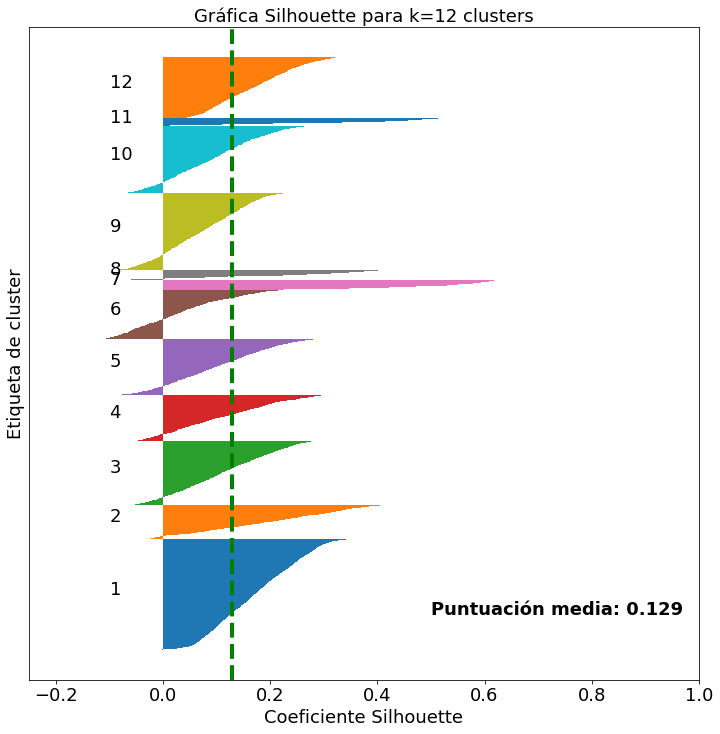

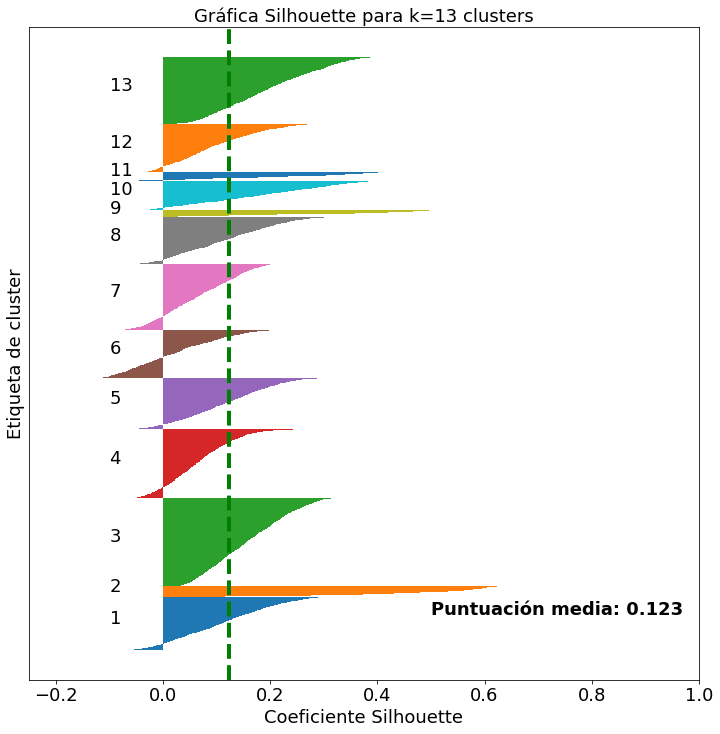

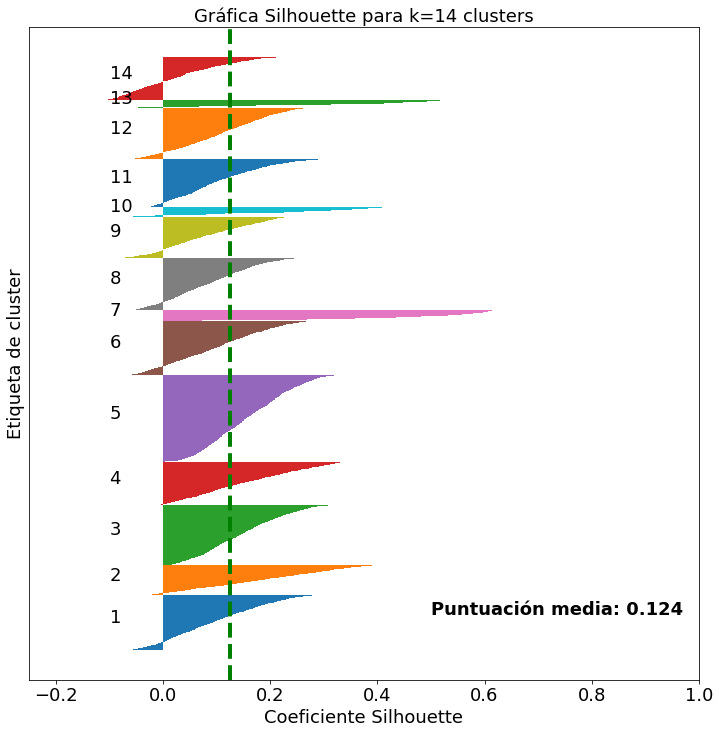

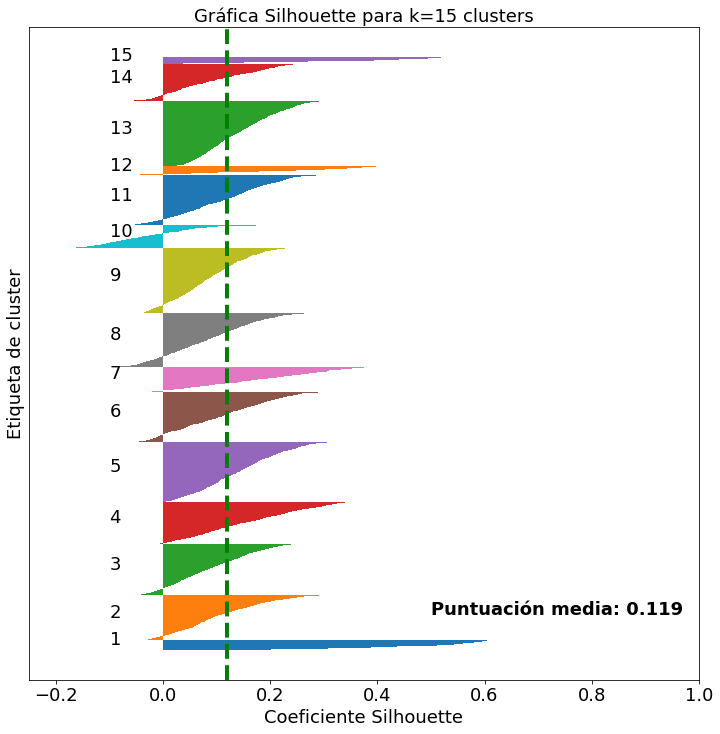

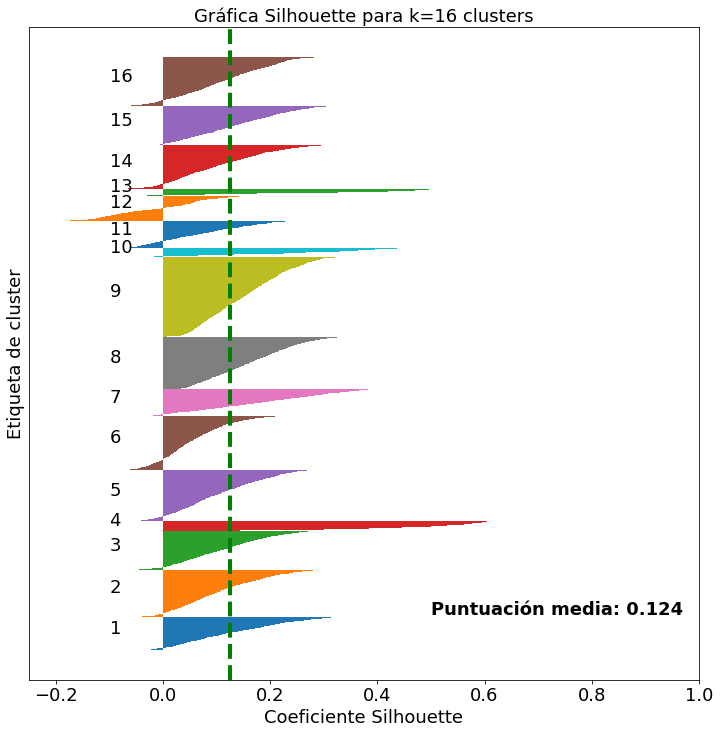

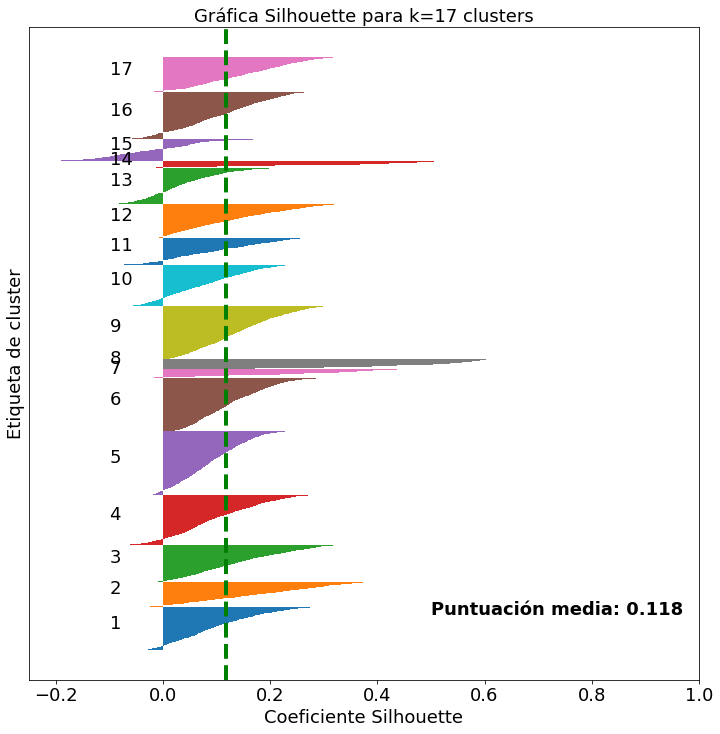

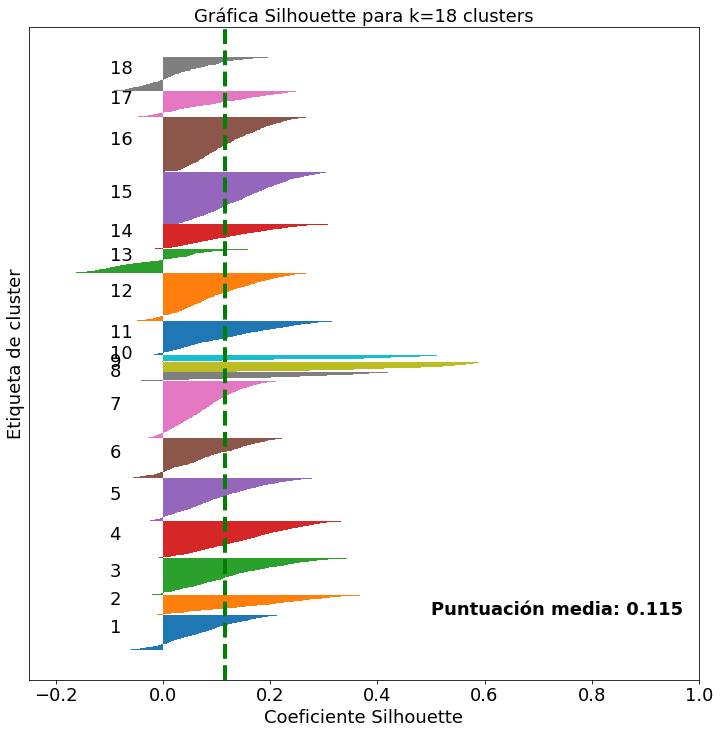

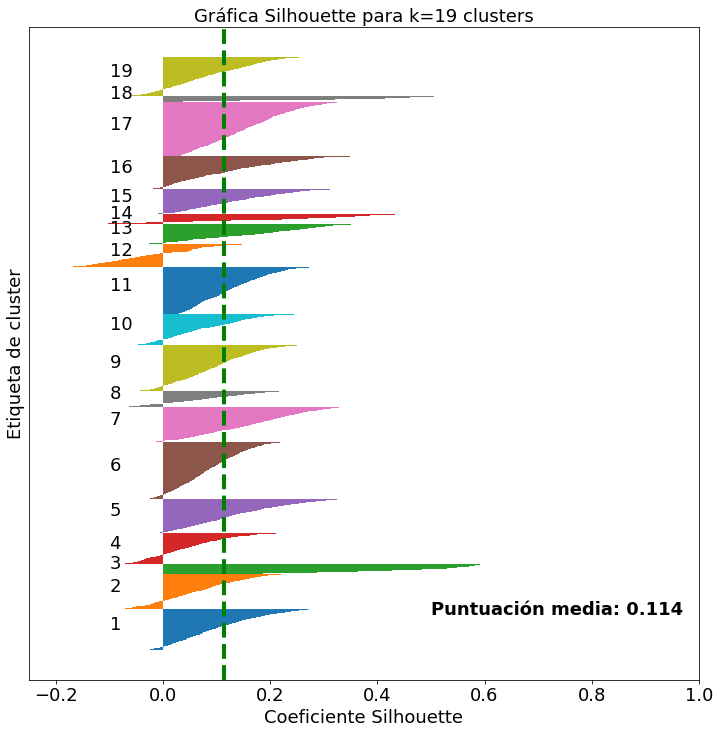

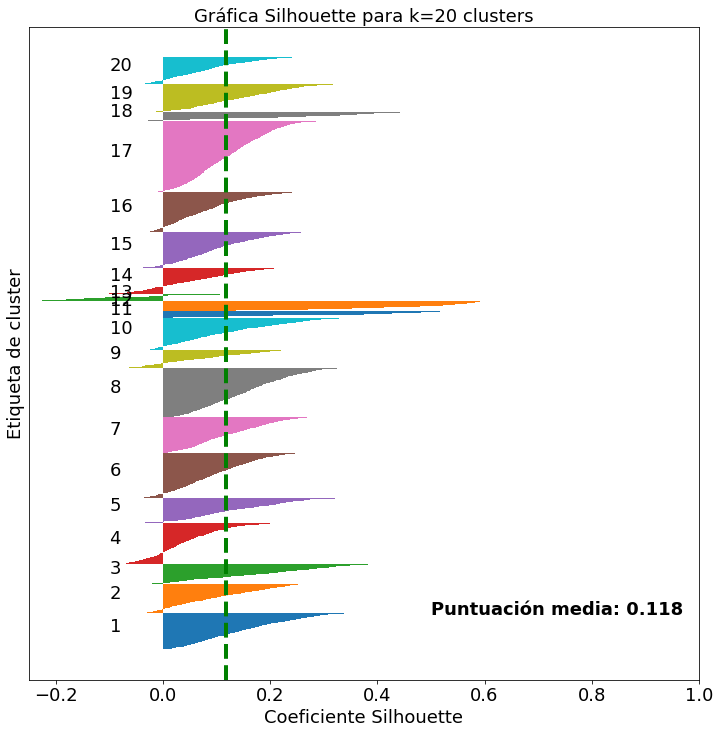

In [22]:
for i, k in enumerate([2, 3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]):
    fig, (ax1) = plt.subplots(1, 1)
    fig.set_size_inches(12, 12)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(logits)

    # Get silhouette samples
    silhouette_vals = silhouette_samples(logits, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.1, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.text(0.6, 0.1, "Puntuación media: {0:.3f}".format(avg_score), fontweight="bold", transform=ax1.transAxes)
    ax1.axvline(avg_score, linestyle='--', linewidth=4, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.25, 1])
    ax1.set_xlabel('Coeficiente Silhouette')
    ax1.set_ylabel('Etiqueta de cluster')
    ax1.set_title('Gráfica Silhouette para k={} clusters'.format(k));
    #fig.savefig("curvas_silhoutte_head/Silhoutte_k{}.pdf".format(k), format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)

In [23]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 20))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(logits)
    sse.append(km.inertia_)

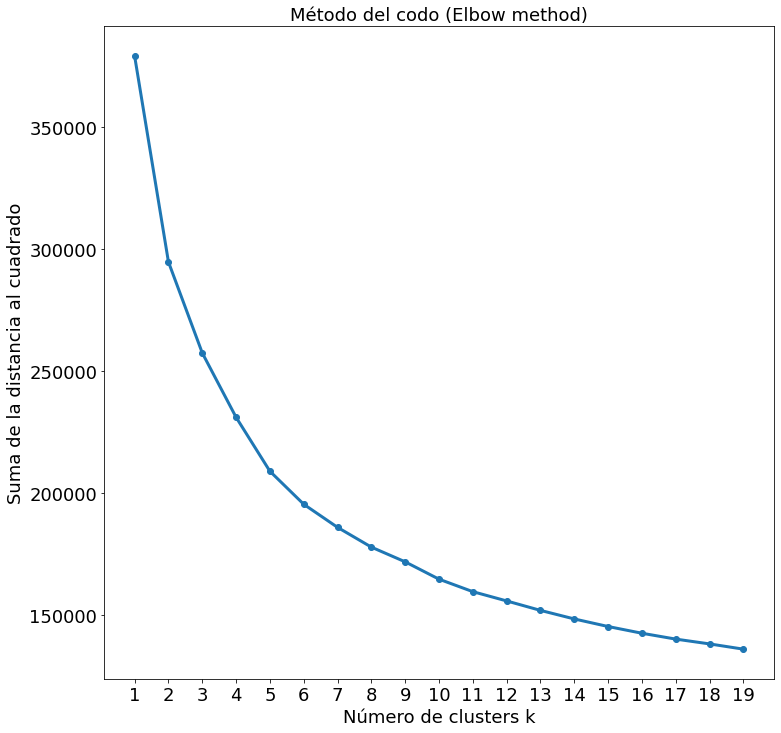

In [24]:
# Plot sse against k
plt.figure(figsize=(12, 12))
plt.plot(list_k, sse, '-o', lw=3)
plt.title('Método del codo (Elbow method)'.format(k))
plt.xlabel(r'Número de clusters k')
plt.xticks(range(1,20))
plt.ylabel('Suma de la distancia al cuadrado');
#plt.savefig("curvas_silhoutte_head/Elbow.pdf", format = 'pdf', dpi=300, bbox_inches = 'tight',pad_inches = 0.1)